# GeoGuessr Machine Learning-Ansatz

## Zusatzinformationen

## Code

### Allgemeine Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Imports für Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import cv2
import os

### Global Variables

### Functions

In [16]:
def get_data(data_dir, labels, appendix, cnt, img_size):
    data = [] 
    for label in labels: 
        internCounter = cnt/len(labels);
        path = os.path.join(data_dir, label, appendix, 'images')
        class_num = labels.index(label)
        for img in os.listdir(path):
            if(internCounter <= 0):
                break;
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = list(cv2.resize(img_arr, (img_size, img_size))) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
            internCounter = internCounter -1;
    return data

In [17]:
def split_train_val(train, val, img_size):
    x_train = []
    y_train = []
    x_val = []
    y_val = []

    for feature, label in train:
        x_train.append(feature)
        y_train.append(label)

    for feature, label in val:
        x_val.append(feature)
        y_val.append(label)

    # Normalize the data
    x_train = np.array(x_train) / 255
    x_val = np.array(x_val) / 255

    x_train.reshape(-1, img_size, img_size, 1)
    y_train = np.array(y_train)

    x_val.reshape(-1, img_size, img_size, 1)
    y_val = np.array(y_val)
    
    return x_train, y_train, x_val, y_val

In [18]:
def generate_model(img_size):
    model = Sequential()
    model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size, img_size, 3)))
    model.add(MaxPool2D())

    model.add(Conv2D(32, 3, padding="same", activation="relu"))
    model.add(MaxPool2D())

    model.add(Conv2D(64, 3, padding="same", activation="relu"))
    model.add(MaxPool2D())
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dense(len(cities), activation="softmax"))
    
    return model

In [6]:
def train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range):
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

    history = model.fit(x_train,y_train,epochs = epoch_range , validation_data = (x_val, y_val))
    
    return model, history

In [7]:
def plot_history(history, epoch_range):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epoch_range)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt
    

In [8]:
def get_metrics(model, labels, x_val, y_val):
    predictionOdds = model.predict(x_val)
    predictions = []
    for pred in predictionOdds:
        predictions.append(list(pred).index(max(pred)))

    predictions = np.array(predictions)
    predictions = predictions.reshape(1,-1)[0]
    return classification_report(y_val, predictions, target_names = labels);

In [15]:
def create_neural_network(img_size, processed_images, train_split, labels, epoch_range, learning_rate):
    train_images = int(processed_images * train_split)
    val_images = int(processed_images - train_images)
    
    train = get_data('E:\Datasets\Strassenbilder Weltweit\Dataset_S', labels, 'database', train_images, img_size)
    val = get_data('E:\Datasets\Strassenbilder Weltweit\Dataset_S', labels, 'query', val_images, img_size)
                  
    x_train, y_train, x_val, y_val = split_train_val(train, val, img_size)
    
    datagen = data_augmentation(x_train)
    
    model = generate_model(img_size)
    print(model.summary())
    
    model, history = train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range)
    
    plt = plot_history(history, epoch_range)
    metrics = get_metrics(model, labels, x_val, y_val)
    
    

### Deep Learning

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 450, 450, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 225, 225, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 225, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0

C:\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


51/51 [==============================] - 76s 1s/step - loss: 1.7927 - accuracy: 0.1854 - val_loss: 1.7757 - val_accuracy: 0.2736
Epoch 2/5
51/51 [==============================] - 73s 1s/step - loss: 1.7732 - accuracy: 0.2191 - val_loss: 1.7601 - val_accuracy: 0.3134
Epoch 3/5
51/51 [==============================] - 72s 1s/step - loss: 1.7568 - accuracy: 0.2815 - val_loss: 1.7436 - val_accuracy: 0.3383
Epoch 4/5
51/51 [==============================] - 72s 1s/step - loss: 1.7350 - accuracy: 0.3265 - val_loss: 1.7272 - val_accuracy: 0.3632
Epoch 5/5
13/13 [==============================] - 3s 224ms/step


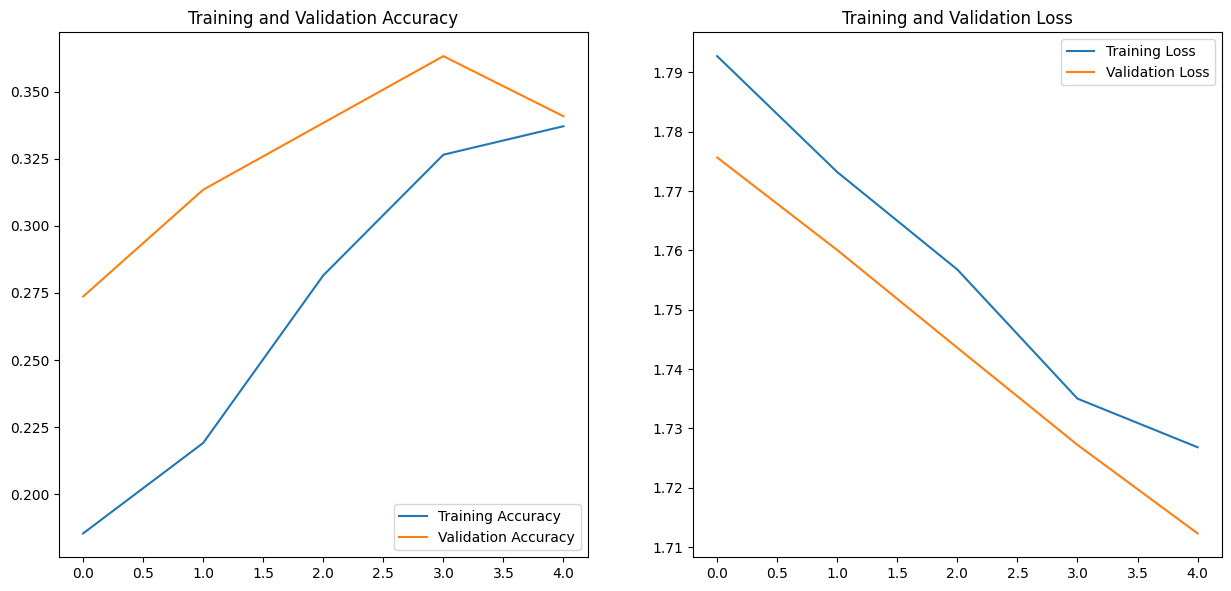

In [19]:
cities = ['berlin', 'kampala', 'melbourne', 'saopaulo', 'sf', 'tokyo']
create_neural_network(450, 2000, 0.8, cities, 5, 0.000001)

In [35]:
#img_size = 450
#epoch_range = 50
#cities = ['berlin', 'kampala', 'melbourne', 'saopaulo', 'sf', 'tokyo']
#train_images = 1600
#val_images = 400
#learning_rate = 0.000001

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 450, 450, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 225, 225, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 225, 225, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)      

Epoch 1/50
26/26 [==============================] - 38s 1s/step - loss: 1.7816 - accuracy: 0.1965 - val_loss: 1.7749 - val_accuracy: 0.1912
Epoch 2/50
26/26 [==============================] - 39s 1s/step - loss: 1.7720 - accuracy: 0.2774 - val_loss: 1.7659 - val_accuracy: 0.2549
Epoch 3/50
26/26 [==============================] - 38s 1s/step - loss: 1.7647 - accuracy: 0.2910 - val_loss: 1.7563 - val_accuracy: 0.3382
Epoch 4/50
26/26 [==============================] - 38s 1s/step - loss: 1.7525 - accuracy: 0.3470 - val_loss: 1.7463 - val_accuracy: 0.4167
Epoch 5/50
26/26 [==============================] - 38s 1s/step - loss: 1.7436 - accuracy: 0.4005 - val_loss: 1.7343 - val_accuracy: 0.4706
Epoch 6/50
26/26 [==============================] - 38s 1s/step - loss: 1.7300 - accuracy: 0.4341 - val_loss: 1.7229 - val_accuracy: 0.4559
Epoch 7/50
26/26 [==============================] - 38s 1s/step - loss: 1.7157 - accuracy: 0.4478 - val_loss: 1.7117 - val_accuracy: 0.4363
Epoch 8/50
26/26 [==

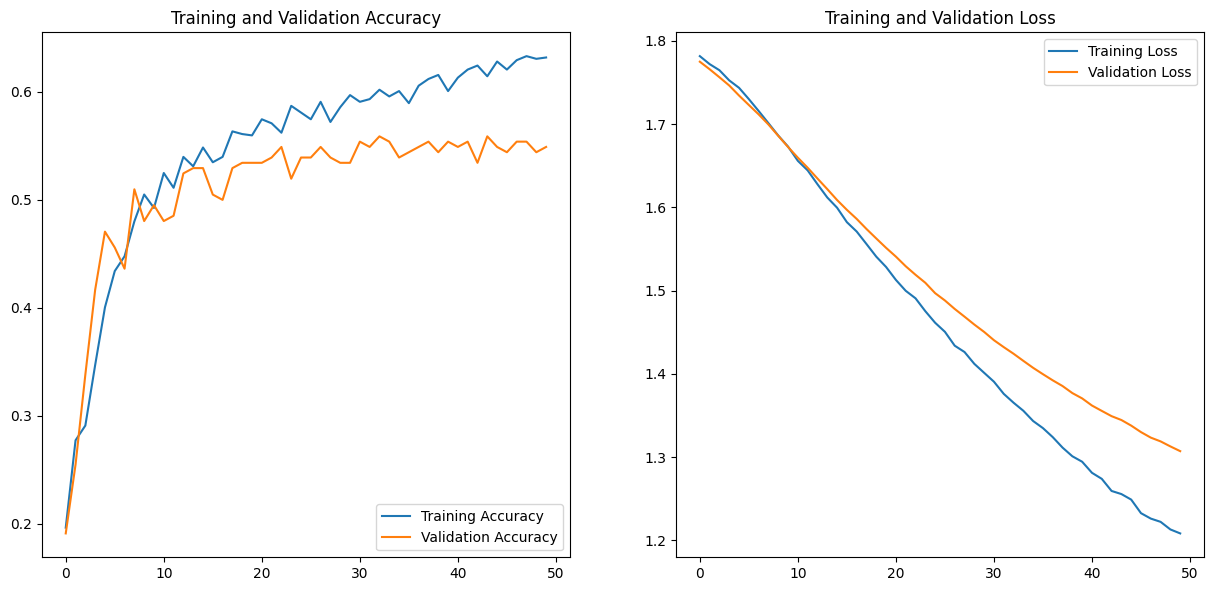

7/7 [==============================] - 2s 232ms/step
              precision    recall  f1-score   support

      berlin       0.43      0.26      0.33        34
     kampala       0.23      0.24      0.23        34
   melbourne       0.78      0.21      0.33        34
    saopaulo       0.00      0.00      0.00        34
          sf       0.22      0.35      0.27        34
       tokyo       0.29      0.74      0.42        34

    accuracy                           0.30       204
   macro avg       0.33      0.30      0.26       204
weighted avg       0.33      0.30      0.26       204



C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
